####**Business Domain Value:**
<p>
Automating Pneumonia screening in chest radiographs, providing affected area details through bounding box. 
</p>
<p>
Assist physicians to make better clinical decisions or even replace human judgement in certain functional areas of healthcare (eg, radiology).
</p>
<p>
Guided by relevant clinical questions, powerful AI techniques can unlock clinically relevant information hidden in the massive amount of data, which in turn can assist clinical decision making.
</p>



In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.patches as patches
from skimage.color import gray2rgb
import h5py
import tensorflow as tf
from keras.utils.vis_utils import plot_model
from tensorflow.keras.applications.vgg16 import preprocess_input as input16
from tensorflow.keras.applications.vgg19 import preprocess_input as input19
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
warnings.filterwarnings('ignore')

**Functions for general purpose**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def show_top_images_with_lables(images, lables, plot_random=True, cmap='gray'):
  columns = 4
  rows = 5
  fig=plt.figure(figsize=(12, 17))
  for i in range(1, columns*rows +1):
    index = None
    if plot_random == True:
      index = randint(0, (len(lables)-1))
    else:
      index = i
    fig.add_subplot(rows, columns, i).set_title(lables[index-1])
    plt.imshow(images[index-1], cmap=cmap)
  return plt.show()

def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou


**Reading Data From Pickle and Basic EDA**

In [37]:
pickle_path = '/content/drive/MyDrive/Shared_Data_Folder/CapstoneData/RSNA-Pneumonia-Detection-Chalenge.pkl'
dataset_file = open(pickle_path, 'rb')
dataset = pickle.load(dataset_file)
dataset_file.close()

In [38]:
dataset.keys()

dict_keys(['TrainingImagesData', 'TrainingImageNames', 'TestingImageData', 'TestImageNames'])

In [ ]:
image_data = dataset['TrainingImagesData']
image_name = dataset['TrainingImageNames']

In [39]:
test_image_data = dataset["TestingImageData"]
test_image_names = dataset["TestImageNames"]

In [ ]:
image_data.shape

(26684, 224, 224)

In [ ]:
image_data[1].shape

(224, 224)

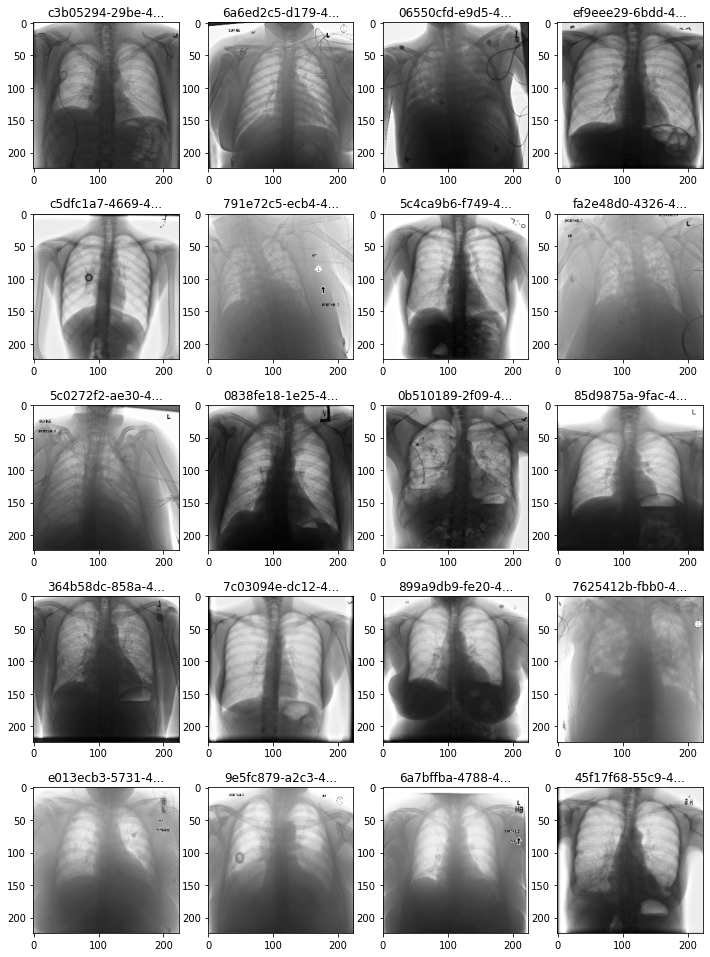

In [ ]:
show_top_images_with_lables(image_data, ['{}...'.format(image[0:15]) for image in image_name], False)

In [ ]:
lables_path = '/content/drive/MyDrive/Shared_Data_Folder/CapstoneData/RSNA-Pneumonia-Detection-Chalenge_lables.pkl'
lables_file = open(lables_path, 'rb')
lable_dataset = pickle.load(lables_file)
lables_file.close()

In [ ]:
lable_dataset.columns

Index(['patientId', 'x', 'y', 'width', 'height', 'Target'], dtype='object')

In [ ]:
lable_dataset.shape

(30227, 6)

**Checking form null or missing values**

In [ ]:
null_df = pd.DataFrame(lable_dataset.isnull().sum().index, columns=['Names'])
null_df['Has Null'] = lable_dataset.isnull().any().values
null_df['Null Counts'] = lable_dataset.isnull().sum().values
null_df

,Names,Has Null,Null Counts
0,patientId,False,0
1,x,True,20672
2,y,True,20672
3,width,True,20672
4,height,True,20672
5,Target,False,0


**Insight:** These are the numbers x-ray images which dont have any infection ie 20672/26684 X-rays images appeart to be normal

**Unique Values of the dataset**

In [ ]:
unique_lable_df = lable_dataset.drop_duplicates(subset=['patientId'])
unique_lable_df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [ ]:
unique_lable_df.Target.value_counts()

0    20672
1     6012
Name: Target, dtype: int64

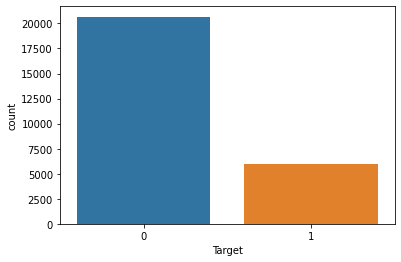

In [ ]:
sns.countplot(unique_lable_df.Target)

**Conclusion:** 6012/26684 of are having infection and 20672/26684 dose not have infection

In [ ]:
duplicate_rows = lable_dataset.duplicated(subset=['patientId'])
duplicate_rows = [i for i, row in enumerate(duplicate_rows) if row == True]
duplicate_rows_indexs_df = pd.DataFrame(duplicate_rows, columns=['Indexs'])
duplicate_rows_indexs_df.head(10)

,Indexs
0,5
1,9
2,15
3,17
4,20
5,25
6,28
7,33
8,37
9,42


In [ ]:
duplicate_rows_indexs_df.shape

(3543, 1)

In [ ]:
duplicate_rows_df = lable_dataset.iloc[duplicate_rows_indexs_df.Indexs]
duplicate_rows_df.head(5)

,patientId,x,y,width,height,Target
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1
15,00aecb01-a116-45a2-956c-08d2fa55433f,547.0,299.0,119.0,165.0,1
17,00c0b293-48e7-4e16-ac76-9269ba535a62,650.0,511.0,206.0,284.0,1
20,00f08de1-517e-4652-a04f-d1dc9ee48593,571.0,275.0,230.0,476.0,1


**Conclusion:** Above are the of patient id where infection is found in both in lungs ie 3543/6012 have infuction in both lungs

In [ ]:
temp_ddf = duplicate_rows_df.head(25)

In [ ]:
coordinates = []
image_names = []
for row in temp_ddf.values:  
  row_values = lable_dataset[lable_dataset.patientId == row[0]].values
  coordinate_list = []
  for row_value in row_values:
    x_min = int((row_value[1]/1024) * 224)
    y_min = int((row_value[2]/1024) * 224)
    width = int((row_value[3]/1024) * 224)
    height= int((row_value[4]/1024) * 224)
    coordinate_list.append([x_min, y_min, width,height])
  coordinates.append(coordinate_list)
  image_names.append(row_values[0][0])
  

In [ ]:
coordinates[10]

[[46, 127, 52, 29], [145, 118, 48, 44]]

In [ ]:
len(coordinates)

25

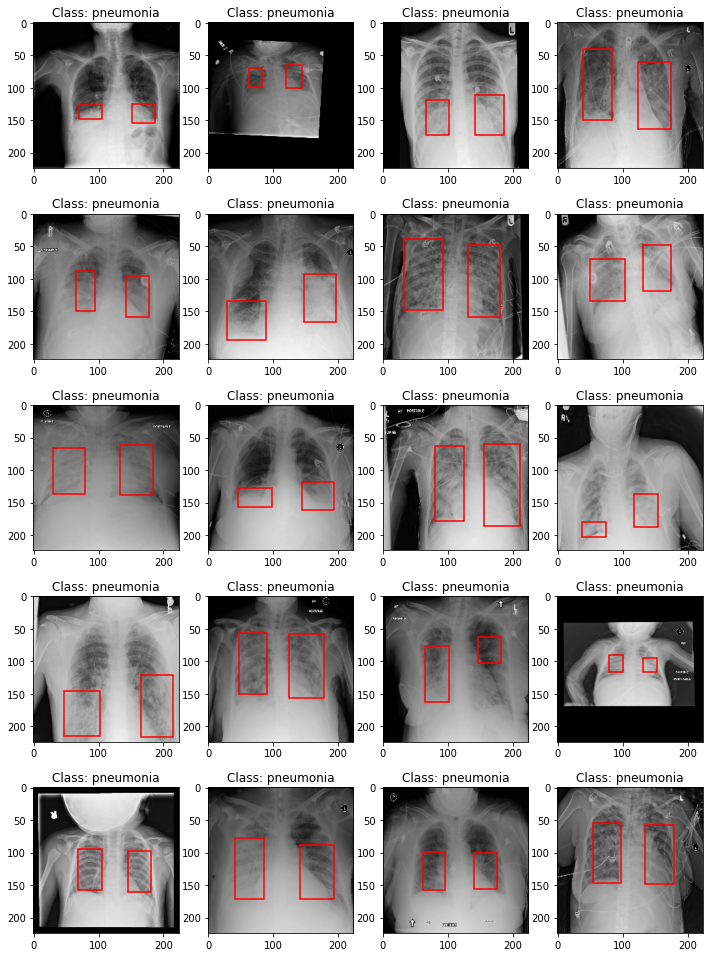

In [ ]:
columns = 4
rows = 5
fig_patch_plt = plt.figure(figsize=(12, 17))
df_values = temp_ddf.head(25).values
for i in range(1, columns*rows +1):
  ax_sub_plt = fig_patch_plt.add_subplot(rows, columns, i)
  img_name_val = df_values[i][0]
  index = np.where(image_name == '{}.dcm'.format(img_name_val.replace('\t', '')))[0][0]
  ax_sub_plt.imshow(image_data[index], cmap='gray')
  ax_sub_plt.set_title("Class: pneumonia")
  for c in coordinates[i]:
    x, y, w, h = c
    rect = patches.Rectangle((x,y), w, h, linewidth=1.5, edgecolor='r', facecolor='none')
    ax_sub_plt.add_patch(rect)
plt.show()

We have completed the EDA part of the project and the insights are also provided above within EDA part. Our next plan of action is as follows:

<ol>
<li>Using simple CNN model to detect to make classification whether X-ray image has pneumonia or not.
 </li>
 <li> Based on our model accuracy we will try different complex models to gain maximum accuracy.
 </li>
 <li> The models which we are planning to use are Mobilnet(U-Net Model for semantic segmentation, RCNN, custom model which will be the combination of CNN for classification and regression for bonding box detection and finally yolo model.
 </li>
</ol>

In [ ]:
unique_lable_df_filled = unique_lable_df.fillna(0)
unique_lable_df_filled.isnull().sum()

patientId    0
x            0
y            0
width        0
height       0
Target       0
dtype: int64

**Preparing Data From Model Building**

In [ ]:
data_targets_bbox = []
data_images = []
data_target_cc = []
data_file_names = []
print("Preparing Data...")
for row in tqdm(unique_lable_df_filled.values):
  file_name = "{}.dcm".format(row[0])
  index = np.where(image_name == file_name)[0][0]
  image = image_data[index]
  image = gray2rgb(image)
  image = input16(image)
  data_images.append(image)
  data_target_cc.append(row[5])
  '''
  The coordinates where originally for image size 1024x1024
  so scaling the coordinates for generalization
  '''
  x = float(row[1])/1024
  y = float(row[2])/1024
  w = float(row[3])/1024
  h = float(row[4])/1024
  data_targets_bbox.append([x,y,w,h])
  data_file_names.append(file_name)

dt = h5py.special_dtype(vlen=str)
data_targets_bbox = np.array(data_targets_bbox, dtype="float32")
data_images = np.array(data_images, dtype="float32")
data_target_cc = np.array(data_target_cc)
data_file_names = np.array(data_file_names, dtype=dt)
print("Data Preparing Completed...")

Preparing Data...



Data Preparing Completed...


In [ ]:
print("Saving processed data....")
with h5py.File("ProcessedDataset.h5", 'w') as f:
  f.create_dataset("data_images", data=data_images)
  f.create_dataset("data_target_cc", data=data_target_cc)
  f.create_dataset("data_targets_bbox", data=data_targets_bbox)
  f.create_dataset("data_file_names", data=data_file_names)
print("Processed data saved....")

Saving processed data....
Processed data saved....


In [ ]:
print("Moving To Drive...")
!mv /content/ProcessedDataset.h5 /content/drive/MyDrive/Shared_Data_Folder/CapstoneData/
print("Moved To Drive.")

Moving To Drive...
Moved To Drive.


In [ ]:
processed_datapath = '/content/drive/MyDrive/Shared_Data_Folder/CapstoneData/ProcessedDataset.h5'
h5Dataset = h5py.File(processed_datapath, 'r')

In [ ]:
print("Reading Data....")
data_images = h5Dataset["data_images"]
data_target_cc = h5Dataset["data_target_cc"]
data_targets_bbox = h5Dataset["data_targets_bbox"]
data_file_names = h5Dataset["data_file_names"]
data_images = data_images[:]
data_target_cc = data_target_cc[:]
data_targets_bbox = data_targets_bbox[:]
data_file_names = data_file_names[:]
print("Completed...")

Reading Data....
Completed...


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dense, Activation, Flatten, Dropout, Input
from tensorflow.keras.applications import VGG19 as PTM_19, VGG16 as PTM_16
from keras.models import Sequential
from keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam as adm , SGD as sgd

**TRAIN TEST SPLIT OF THE DATA**

In [ ]:
train_test_split_data = train_test_split(data_images, data_target_cc, data_targets_bbox, data_file_names, test_size=0.3, random_state=42)

In [ ]:
del data_images
del data_target_cc
del data_targets_bbox
del data_file_names
del processed_datapath
del h5Dataset

In [ ]:
X_train, X_test = train_test_split_data[:2]
y_train_clf, y_test_clf = train_test_split_data[2:4]
y_train_bbox, y_test_bbox = train_test_split_data[4:6]
y_train_fn, y_test_fn = train_test_split_data[6:]

In [ ]:
del train_test_split_data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[29.53125, 117.25, 52.0625, 75.6875]
1


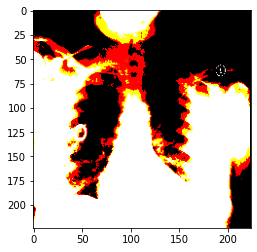

In [ ]:
i = 1
plt.imshow(X_train[i])
print(list(np.array(y_train_bbox[i]) * 224))
print(y_train_clf[i])

In [ ]:
y_train_clf = tf.keras.utils.to_categorical(y_train_clf, num_classes=2)
y_test_clf = tf.keras.utils.to_categorical(y_test_clf, num_classes=2)

In [ ]:
X_train.shape, X_test.shape

((18678, 224, 224, 3), (8006, 224, 224, 3))

In [ ]:
y_train_clf.shape, y_test_clf.shape

((18678, 2), (8006, 2))

In [ ]:
y_train_bbox.shape, y_test_bbox.shape

((18678, 4), (8006, 4))

In [ ]:
y_train_clf.shape

(18678, 2)

In [ ]:
# construct a dictionary for our target training outputs
y_train = {
	"classification_layer": y_train_clf,
	"bounding_box_layer": y_train_bbox
}
# construct a second dictionary, this one for our target testing
# outputs
y_test = {
	"classification_layer": y_test_clf,
	"bounding_box_layer": y_test_bbox
}

In [ ]:
# define a dictionary to set the loss methods
# cross-entropy for the classification layers and mean absolute error
# for the bounding box layers
#,binary_crossentropy
losses = {
	"classification_layer": "categorical_crossentropy", 
	"bounding_box_layer": "mean_squared_error"
}

In [ ]:
# put together our model which accept an input image and then output
# bounding box coordinates and a class label
ptm_16 = PTM_16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

ptm_16.trainable = False # freeze all VGG16 layers so they will not be updated during the training process
flatten = ptm_16.output 
flatten = Flatten()(flatten)  #flatten the max-pooling output of VGG16

# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bbox_layer = Dense(256, activation="relu")(flatten)
bbox_layer = Dropout(0.5)(flatten)
bbox_layer = Dense(128, activation="relu")(bbox_layer)
bbox_layer = Dropout(0.5)(bbox_layer)
bbox_layer = Dense(64, activation="relu")(bbox_layer)
bbox_layer = Dropout(0.5)(bbox_layer)
bbox_layer = Dense(32, activation="relu")(bbox_layer)
bbox_layer = Dropout(0.5)(bbox_layer)
# bbox_layer = Dense(16, activation="relu")(bbox_layer)
# bbox_layer = Dropout(0.5)(bbox_layer)
# bbox_layer = Dense(8, activation="relu")(bbox_layer)
# bbox_layer = Dropout(0.5)(bbox_layer)
bbox_layer = Dense(4, activation="sigmoid", name="bounding_box_layer")(bbox_layer)

# construct a second fully-connected layer head, this one to predict
# the class label
classification_layer = Dense(512, activation="relu")(flatten)
classification_layer = Dropout(0.5)(classification_layer)
classification_layer = Dense(512, activation="relu")(classification_layer)
classification_layer = Dropout(0.5)(classification_layer)
classification_layer = Dense(y_test_clf.shape[1], activation="softmax", name="classification_layer")(classification_layer)

model = Model(inputs=ptm_16.input, outputs=(bbox_layer, classification_layer))
optimizer = adm(lr=1e-4)
model.compile(loss=losses, optimizer=optimizer, metrics=["accuracy"])

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

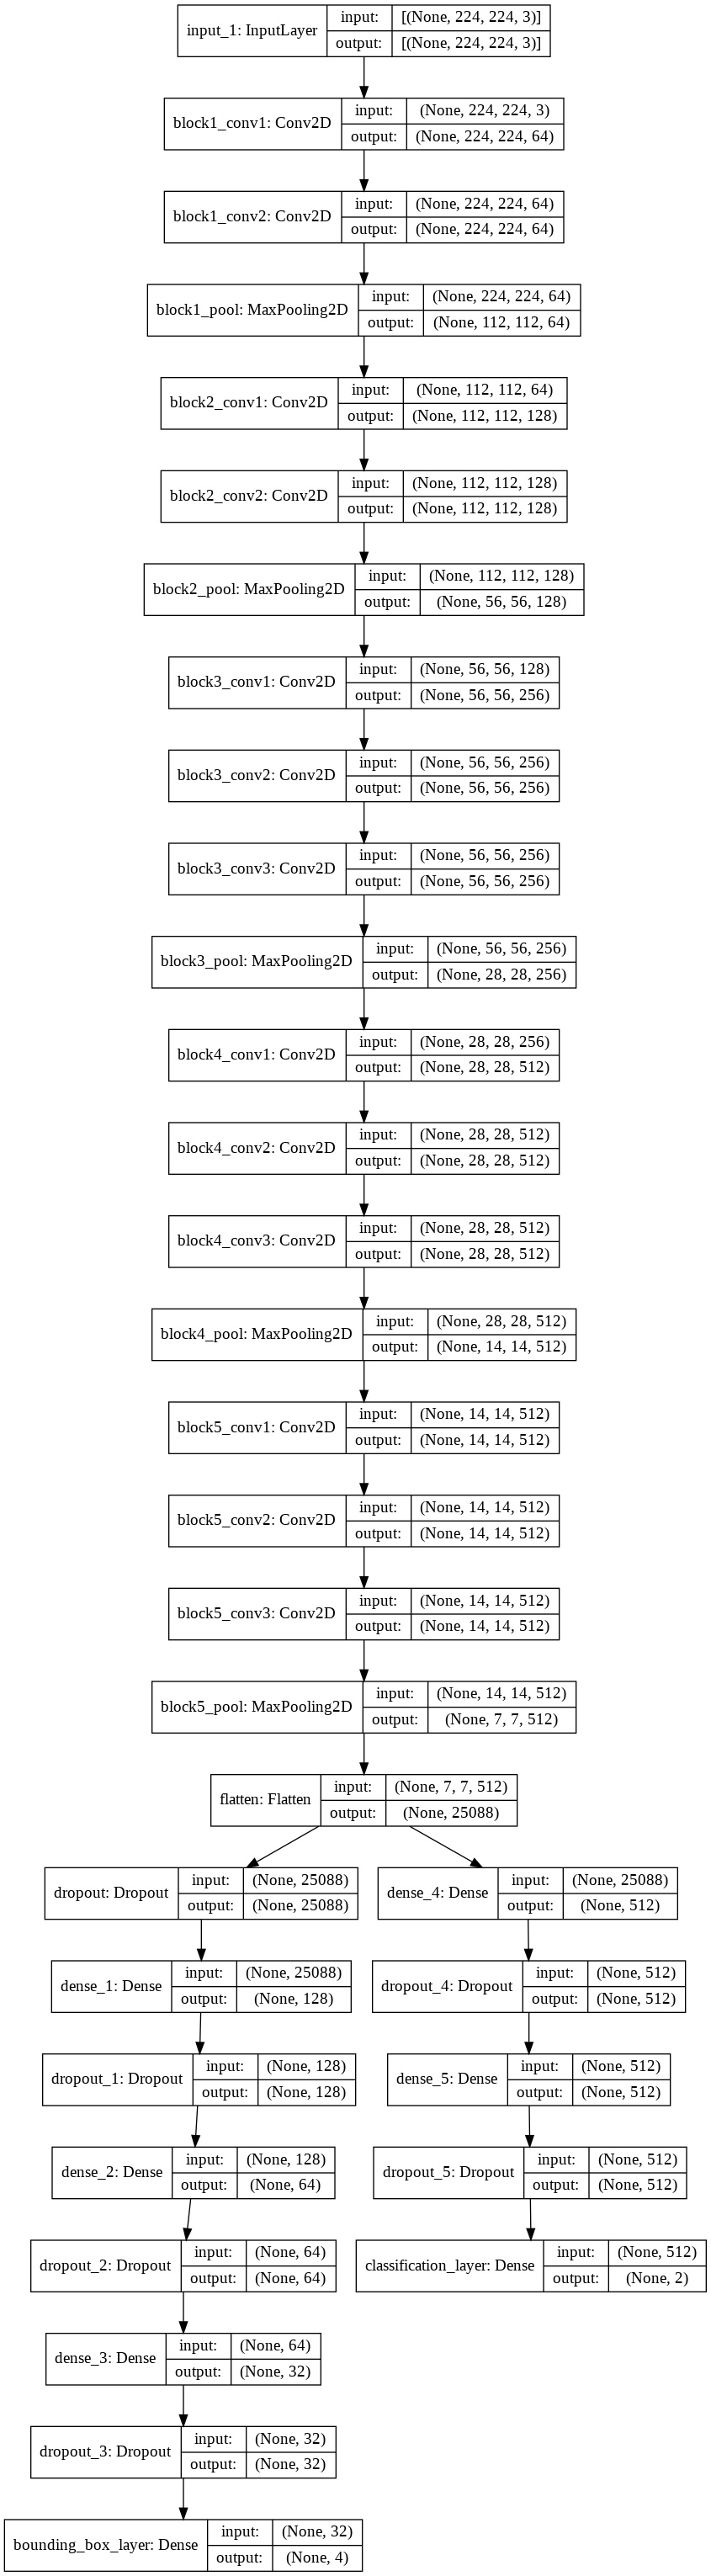

In [ ]:
plot_model(model, 'My_clf_bbox_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
batch_size = 20
epochs = 20

In [ ]:
check_point_path = '/content/drive/MyDrive/Shared_Data_Folder/CapstoneData/ModelCheckPoint/M1/model-weights-{val_bounding_box_layer_accuracy:.2f}--{val_classification_layer_accuracy:.2f}.h5'

In [ ]:
checkpoint = ModelCheckpoint(check_point_path, monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True) # To Save the weight of the best performing model
early_stop = EarlyStopping(monitor="val_loss", patience=5) #Stop Early if the model converges very quickly before it over fits.

In [ ]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[checkpoint,early_stop])

Epoch 1/20
934/934 [==============================] - 980s 1s/step - loss: 2.1549 - bounding_box_layer_loss: 0.1659 - classification_layer_loss: 1.9890 - bounding_box_layer_accuracy: 0.3748 - classification_layer_accuracy: 0.7298 - val_loss: 0.4738 - val_bounding_box_layer_loss: 0.0289 - val_classification_layer_loss: 0.4450 - val_bounding_box_layer_accuracy: 0.7828 - val_classification_layer_accuracy: 0.7782

Epoch 00001: val_loss improved from inf to 0.47385, saving model to /content/drive/MyDrive/Shared_Data_Folder/CapstoneData/ModelCheckPoint/M1/model-weights-0.78--0.78.h5
Epoch 2/20
934/934 [==============================] - 1044s 1s/step - loss: 0.5772 - bounding_box_layer_loss: 0.0727 - classification_layer_loss: 0.5045 - bounding_box_layer_accuracy: 0.5375 - classification_layer_accuracy: 0.7754 - val_loss: 0.4929 - val_bounding_box_layer_loss: 0.0289 - val_classification_layer_loss: 0.4640 - val_bounding_box_layer_accuracy: 0.8601 - val_classification_layer_accuracy: 0.7780

E

In [ ]:
i= 1005
image = test_image_data[i]
image = gray2rgb(image)
image = input16(image)
image = np.expand_dims(image, axis=0)
pred = model.predict(image)
print(pred[1])
print(pred[0])

[[0.9935009  0.00649912]]
[[0. 0. 0. 0.]]


**MobileNet Model For Sementic segmentation**

In [3]:
!wget https://kkb-production.jupyter-proxy.kaggle.net/k/62927870/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2IiwidHlwIjoiSldUIn0..DV_CyqCxB7TyYqm-vsj8dw.g-DK_AysZDJIKFf11xL_BFHLolWQUZBnHl1Rcgl6_JUD5BuKw1CGhzCrylUkl5Gh-uJV8g-OpcTZTDLb53_DYNtt3-LDEsyKcfDWkvG9XsG39Nr8JFBuyrlCJIOYSQZ8l2WZ6IG1mgPGdYe9DHl2eQm4cQ4dw7FWIpGTavadM9DFGUe12nJTY81dKcmF5ndjOuromedMJ_-PBb8MMBvqOA.st1lyEIDIgBLqOQ9UmXwNg/proxy/files/training_data_images_respampled.npy

--2021-05-15 11:23:43--  https://kkb-production.jupyter-proxy.kaggle.net/k/62927870/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2IiwidHlwIjoiSldUIn0..DV_CyqCxB7TyYqm-vsj8dw.g-DK_AysZDJIKFf11xL_BFHLolWQUZBnHl1Rcgl6_JUD5BuKw1CGhzCrylUkl5Gh-uJV8g-OpcTZTDLb53_DYNtt3-LDEsyKcfDWkvG9XsG39Nr8JFBuyrlCJIOYSQZ8l2WZ6IG1mgPGdYe9DHl2eQm4cQ4dw7FWIpGTavadM9DFGUe12nJTY81dKcmF5ndjOuromedMJ_-PBb8MMBvqOA.st1lyEIDIgBLqOQ9UmXwNg/proxy/files/training_data_images_respampled.npy
Resolving kkb-production.jupyter-proxy.kaggle.net (kkb-production.jupyter-proxy.kaggle.net)... 35.244.180.134
Connecting to kkb-production.jupyter-proxy.kaggle.net (kkb-production.jupyter-proxy.kaggle.net)|35.244.180.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1809948800 (1.7G) [application/octet-stream]
Saving to: ‘training_data_images_respampled.npy’

training_data_image 100%[===================>]   1.69G  83.3MB/s    in 21s     

2021-05-15 11:24:04 (83.0 MB/s) - ‘training_data_images_respampled.npy’

In [4]:
!wget https://kkb-production.jupyter-proxy.kaggle.net/k/62927870/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2IiwidHlwIjoiSldUIn0..DV_CyqCxB7TyYqm-vsj8dw.g-DK_AysZDJIKFf11xL_BFHLolWQUZBnHl1Rcgl6_JUD5BuKw1CGhzCrylUkl5Gh-uJV8g-OpcTZTDLb53_DYNtt3-LDEsyKcfDWkvG9XsG39Nr8JFBuyrlCJIOYSQZ8l2WZ6IG1mgPGdYe9DHl2eQm4cQ4dw7FWIpGTavadM9DFGUe12nJTY81dKcmF5ndjOuromedMJ_-PBb8MMBvqOA.st1lyEIDIgBLqOQ9UmXwNg/proxy/files/training_data_maskes_respampled.npy

--2021-05-15 11:24:36--  https://kkb-production.jupyter-proxy.kaggle.net/k/62927870/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2IiwidHlwIjoiSldUIn0..DV_CyqCxB7TyYqm-vsj8dw.g-DK_AysZDJIKFf11xL_BFHLolWQUZBnHl1Rcgl6_JUD5BuKw1CGhzCrylUkl5Gh-uJV8g-OpcTZTDLb53_DYNtt3-LDEsyKcfDWkvG9XsG39Nr8JFBuyrlCJIOYSQZ8l2WZ6IG1mgPGdYe9DHl2eQm4cQ4dw7FWIpGTavadM9DFGUe12nJTY81dKcmF5ndjOuromedMJ_-PBb8MMBvqOA.st1lyEIDIgBLqOQ9UmXwNg/proxy/files/training_data_maskes_respampled.npy
Resolving kkb-production.jupyter-proxy.kaggle.net (kkb-production.jupyter-proxy.kaggle.net)... 35.244.180.134
Connecting to kkb-production.jupyter-proxy.kaggle.net (kkb-production.jupyter-proxy.kaggle.net)|35.244.180.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4826529920 (4.5G) [application/octet-stream]
Saving to: ‘training_data_maskes_respampled.npy’

training_data_maske 100%[===================>]   4.49G  82.4MB/s    in 56s     

2021-05-15 11:25:32 (82.1 MB/s) - ‘training_data_maskes_respampled.npy’

In [5]:
!mv *.npy /content/drive/MyDrive/Shared_Data_Folder/CapstoneData/

In [87]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input as mob_pre
from tensorflow.keras.applications.imagenet_utils import preprocess_input as imagenet_preprocess_input
from tensorflow.keras.layers import BatchNormalization, Dense, Activation, Flatten, Dropout, Input, Lambda
from tensorflow.keras.layers import Softmax
from tensorflow.keras.layers import ZeroPadding2D,Convolution2D,MaxPooling2D
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam as adm , SGD as sgd
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import backend as K
import pdb
import cv2
import tensorflow
from sklearn.model_selection import train_test_split
from random import randint

In [99]:
def get_coordinates(seg_img, thrushold):
  norm_img = cv2.normalize(seg_img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
  norm_img = norm_img.astype(np.uint8)
  _, difference = cv2.threshold(norm_img, 200, 255, cv2.THRESH_BINARY)
  difference = cv2.dilate(difference, None, iterations=2)
  contours, _ = cv2.findContours(difference.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  coordinates = []
  for count in contours:
    if cv2.contourArea(count) < thrushold:
      continue
    (x, y, w, h) =  cv2.boundingRect(count)
    coordinates.append(list((x, y, w, h)))
  return coordinates

def predict(image, thrushold):
  coordinates = get_coordinates(image, thrushold)
  pred_class = None
  if len(coordinates) > 0:
    pred_class = 1
  else:
    pred_class = 0
  return (pred_class, coordinates)

In [19]:
tf.config.run_functions_eagerly(True)

In [6]:
training_image_data = np.load('/content/drive/MyDrive/Shared_Data_Folder/CapstoneData/training_data_images_respampled.npy')
masked_images = np.load('/content/drive/MyDrive/Shared_Data_Folder/CapstoneData/training_data_maskes_respampled.npy')

In [7]:
image_hight = 224
image_width = 224
alpha = 1 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

In [8]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)
    return numerator / (denominator + tensorflow.keras.backend.epsilon())

def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())


def create_model(trainable=False):
    model = MobileNet(input_shape=(image_hight, image_width, 3), include_top=False, alpha=alpha, weights="imagenet") # Load pre-trained mobilenet
    for layer in model.layers:
        layer.trainable = trainable
         
    block0 = model.get_layer("conv_pw_1_relu").output
    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    block3 = model.get_layer("conv_pw_11_relu").output
    block4 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block4), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = Concatenate()([UpSampling2D()(x), block0])
    x = UpSampling2D()(x)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)

    x = Reshape((image_hight, image_width))(x)

    return Model(inputs=model.input, outputs=x)

In [9]:
model = create_model()
optimizer = adm(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

17227776/17225924 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
______________________________________________________________________________________________

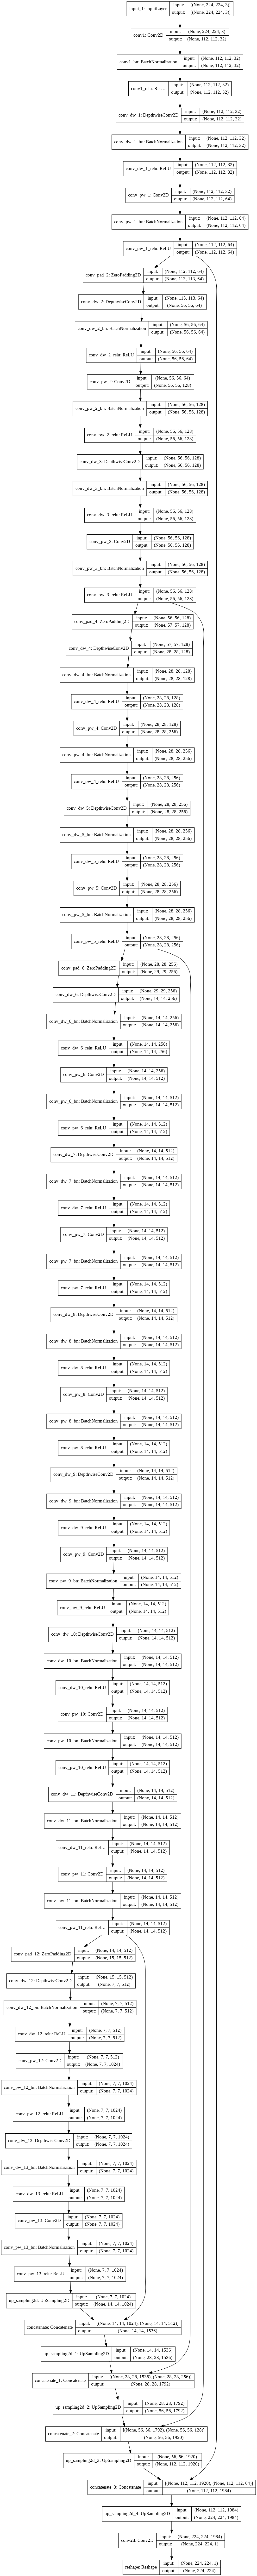

In [ ]:
plot_model(model, 'MobileNet.png',show_shapes=True, show_layer_names=True)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(training_image_data, masked_images, test_size=0.3, random_state=42)

In [11]:
del training_image_data, masked_images

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8416, 224, 224, 3), (3608, 224, 224, 3), (8416, 224, 224), (3608, 224, 224))

In [12]:
X_train = mob_pre(X_train)
X_test = mob_pre(X_test)

In [14]:
check_point_path = "/content/drive/MyDrive/Shared_Data_Folder/CapstoneData/ModelCheckPoint/MobileNet/model-weights-{val_loss:.2f}.h5"
checkpoint = ModelCheckpoint(check_point_path, monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True) # To Save the weight of the best performing model
early_stop = EarlyStopping(monitor="val_loss", patience=5) #Stop Early if the model converges very quickly before it over fits.

In [22]:
#@title No of epoch config
epochs = 50 #@param {type:"integer"}
with tf.device('/device:GPU:0'):
  model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=epochs, batch_size=10, verbose=1, callbacks=[checkpoint])

Epoch 1/50
842/842 [==============================] - 117s 139ms/step - loss: 0.9441 - dice_coefficient: 0.4869 - val_loss: 1.0026 - val_dice_coefficient: 0.4749

Epoch 00001: val_loss improved from 1.00713 to 1.00262, saving model to /content/drive/MyDrive/Shared_Data_Folder/CapstoneData/ModelCheckPoint/MobileNet/model-weights-1.00.h5
Epoch 2/50
842/842 [==============================] - 115s 137ms/step - loss: 0.9522 - dice_coefficient: 0.4849 - val_loss: 1.0020 - val_dice_coefficient: 0.4760

Epoch 00002: val_loss improved from 1.00262 to 1.00203, saving model to /content/drive/MyDrive/Shared_Data_Folder/CapstoneData/ModelCheckPoint/MobileNet/model-weights-1.00.h5
Epoch 3/50
842/842 [==============================] - 116s 137ms/step - loss: 0.9487 - dice_coefficient: 0.4844 - val_loss: 1.0004 - val_dice_coefficient: 0.4762

Epoch 00003: val_loss improved from 1.00203 to 1.00037, saving model to /content/drive/MyDrive/Shared_Data_Folder/CapstoneData/ModelCheckPoint/MobileNet/model-we

In [243]:
model.history.history

{}

In [23]:
model.save("/content/drive/MyDrive/Shared_Data_Folder/CapstoneData/LungsSemanticSegmentation.h5")

In [24]:
model.load_weights('/content/drive/MyDrive/Shared_Data_Folder/CapstoneData/ModelCheckPoint/MobileNet/model-weights-0.99.h5')

In [234]:
i = 131

In [235]:
image = test_image_data[i]
image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
image = mob_pre(image)
image = np.expand_dims(image, axis=0)
pred = model.predict(image)

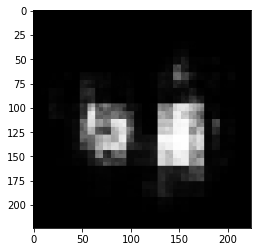

In [236]:
pred = pred[0]
plt.imshow(pred, cmap='gray')

In [237]:
pred_clf, coordinates = predict(pred, 600)
coordinates

[[70, 110, 28, 36], [126, 94, 52, 68]]

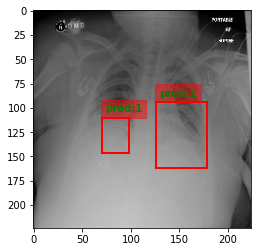

0fb7f9de-9fa3-40b9-bf27-7cea953b6058.dcm
Predicted Class: 1


In [240]:
fig,ax = plt.subplots(1)
ax.imshow(test_image_data[i], cmap='gray') # Display the image
for c in coordinates:
  x, y, w, h = c
  rect = patches.Rectangle((x,y), w, h, linewidth=2, edgecolor='r', facecolor='none')
  ax.add_patch(rect)
  plt.text(x+3, y-6,f'pred:{pred_clf}',color='green', fontweight='extra bold', bbox=dict(facecolor='red', edgecolor='red', alpha=0.45))
plt.show()
print(test_image_names[i])
print(f"Predicted Class: {pred_clf}")

In [2]:
!jupyter nbconvert --to html /content/drive/MyDrive/'Colab Notebooks'/AI_CapstoneProject.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/AI_CapstoneProject.ipynb to html
[NbConvertApp] Writing 3395732 bytes to /content/drive/MyDrive/Colab Notebooks/AI_CapstoneProject.html
